In [1]:
# start by importing the necessities 
import numpy as np 
from astropy.io import fits 
from matplotlib import pyplot as plt 

import glob

In [2]:
# open fits file
path = '/Users/mr82/teaching/data_for_ASTR230/'
ffile = fits.open(path+'m82/obj0063.fits')

Don't forget to update file paths and names appropriate for your own computer and file structure. 

In [3]:
fdata = ffile[0].data 
fheader=ffile[0].header

# Bias subtraction and trimming

The Prime Focus Camera (PFC) at McDonald has a bias strip on the side. The purpose of this strip is to measure the pedestal (bias) value that can be subtracted from each row. 

First, we have to figure out where the bias strip is. You can look at the image in ds9 or python. Notice the strip on the right that is several columns of pixels, all with similar values.  

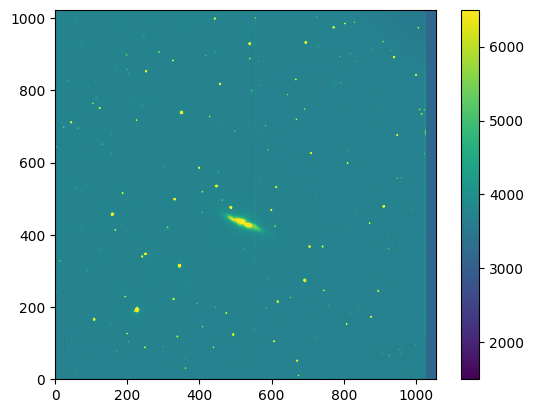

In [4]:
plt.imshow(fdata, origin='lower', vmin=1500, vmax=6500)
plt.colorbar()

The location of the bias strip becomes very obvious when we plot a slice through the image:

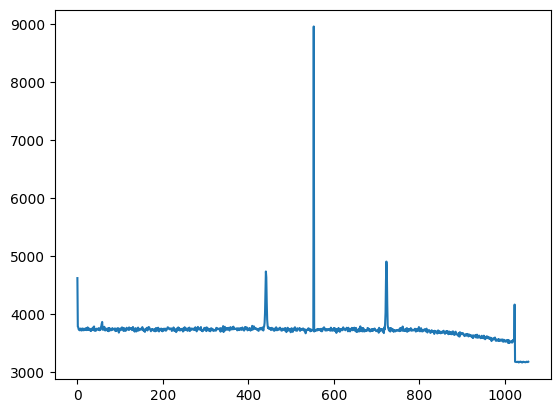

In [5]:
plt.plot(fdata[1000,:])

Try plotting a few different slices through the image. Does the edge of the bias strip move depending on which slice you take? 

We can zoom in on our slice to see more precisely where the bias strip is. 

(2750.0, 5000.0)

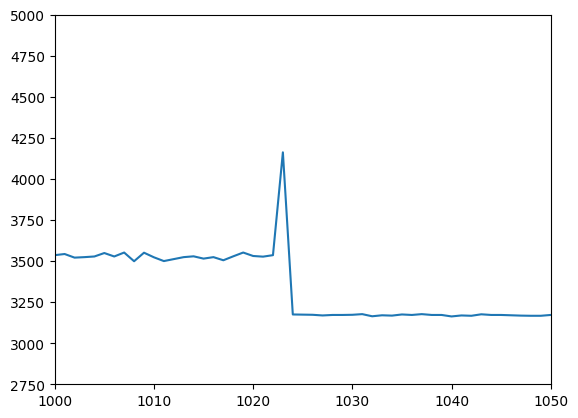

In [6]:
plt.plot(fdata[1000,:])
plt.xlim([1000,1050])
plt.ylim([2750,5000])

Carefully inspect the plot to identify where the data end and the bias strip begins. 

It looks like a good bias section is x = 1025 through 1054 inclusive.

We should also trim the image to remove bad values at the ends. Take a look at a few image slices to see where the data start to look bad. 

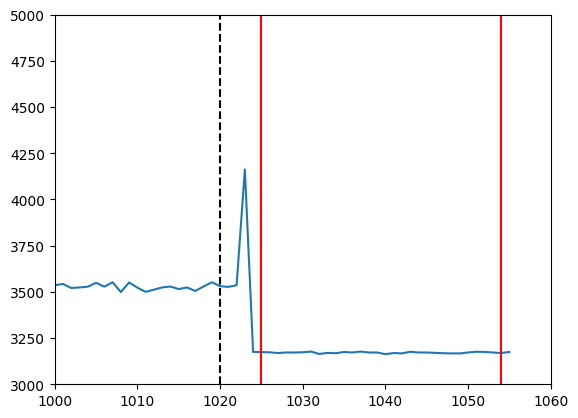

In [7]:
# plot the data 
plt.plot(fdata[1000,:])
plt.xlim([1000,1060])
plt.ylim([3000,5000])

# visualize our threshold values 
# the end of the data
plt.plot([1020,1020], [3000,9000], color='black', linestyle='dashed')
# the bias strip 
plt.plot([1025,1025], [3000,9000], color='red')
plt.plot([1054,1054], [3000,5000], color='red')

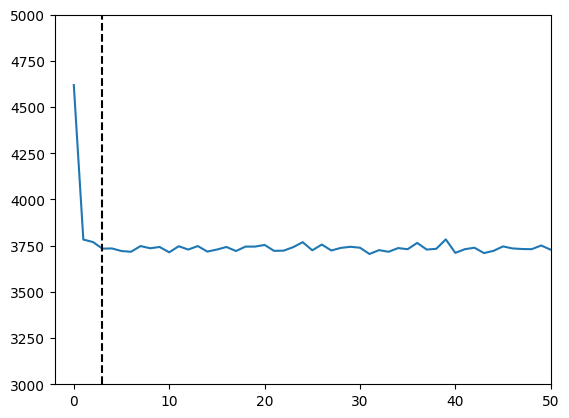

In [8]:
# plot the data 
plt.plot(fdata[1000,:])
plt.xlim([-2,50])
plt.ylim([3000,5000])

# visualize our threshold values 
# the end of the data
plt.plot([3,3], [3000,9000], color='black', linestyle='dashed')

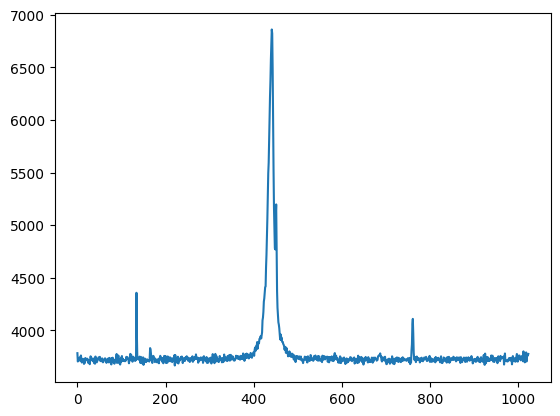

In [9]:
# aaand a slice in y 

# plot the data 
plt.plot(fdata[:,500])


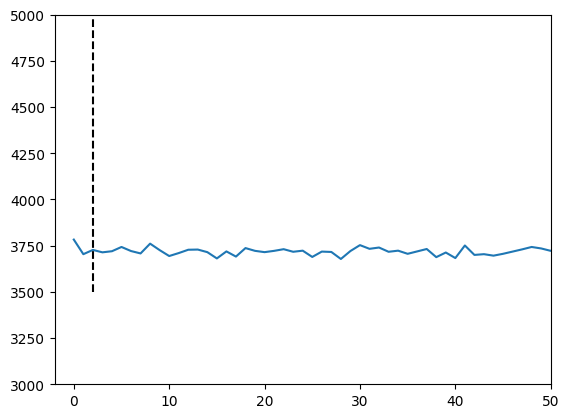

In [10]:
# y limits -- zooming in on the lower end 

# plot the data 
plt.plot(fdata[:,500])
plt.xlim([-2,50])
plt.ylim([3000,5000])

plt.plot([2,2], [3500,5000], color='black', linestyle='dashed')

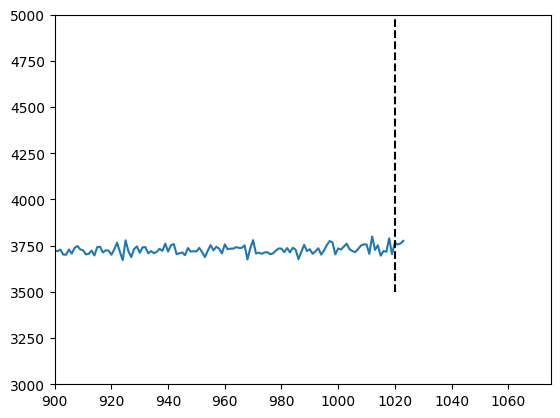

In [11]:
# y limits -- zooming in on the upper end 

# plot the data 
plt.plot(fdata[:,500])
plt.xlim([900,1075])
plt.ylim([3000,5000])

plt.plot([1020,1020], [3500,5000], color='black', linestyle='dashed')

To keep things straight, and in case we’d like to change them later, let’s define the following limits for trimming and for bias extraction, in image coordinates:

In [12]:
x1 = 3     # first good pixel in x after trim
x2 = 1020  # last pixel to include in x after trim

y1 = 2     # first good pixel in y after trim
y2 = 1020  # last pixel to include in y after trim

bx1 = 1025 # first pixel of bias section
bx2 = 1054 # last pixel of bias section

Now we extract the portion of the image that we want to keep:

In [13]:
ndata=fdata[y1:y2,x1:x2] #grabs the good section, but still need to subtract bias

Now we want to subtract the bias from each row of the data. You can do this with a for loop that does the computation line-by-line. 

In [14]:
ndata_rm_bias = np.zeros(ndata.shape)

for y in range(y1,y2):
    ndata_rm_bias[y-y1,:] = ndata[y-y1,:] - np.median(fdata[y,bx1:bx2])

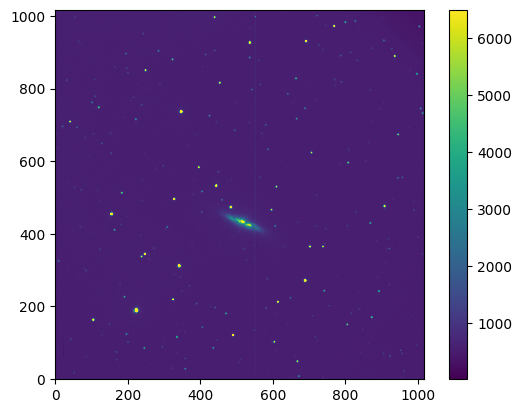

In [15]:
plt.imshow(ndata_rm_bias, origin='lower', vmax=6500)
plt.colorbar()

Loops can be slooooow and painful for large data. We can accomplish the same thing with a little array manipulation instead. 

In [16]:
row_bias = np.median(fdata[y1:y2,bx1:bx2], axis=1)
bias = np.tile(row_bias[:,np.newaxis], (1, ndata.shape[1]))

ndata_no_bias = ndata - bias 

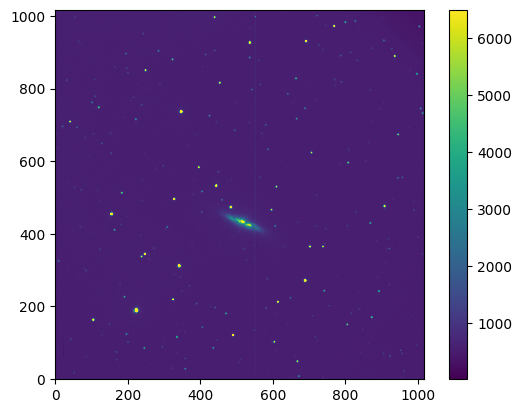

In [17]:
plt.imshow(ndata_no_bias, origin='lower', vmax=6500)
plt.colorbar()

We can check that these two approaches accomplished the same thing by taking the difference. If all went well, we should find zeros everywhere. 

In [18]:
test = ndata_rm_bias - ndata_no_bias
np.nonzero(test) #returns a list with the indices of non-zero elements

(array([], dtype=int64), array([], dtype=int64))

And if we plot the difference image, the value should be zero everywhere. If you see a non-zero value, something went wrong.

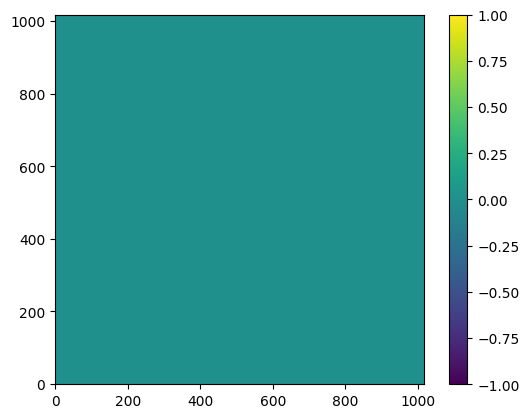

In [19]:
plt.imshow(test, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

Perhaps more elegantly, we can compare whether the two arrays have the same shape and elements using `np.array_equal()`.

In [20]:
np.array_equal(ndata_rm_bias,ndata_no_bias)

True

### What about using a separate bias frame?

Not all imagers have a bias strip on the side of the detector. How do you measure the bias in that case? 

A bias image is an image taken with zero exposure time. Counts in a bias frame are never zero even though this image is taken with no light hitting the CCD and no integration time. CCDs add a voltage offset to all pixels so that when the accumulated signal in each pixel is converted to a number, the number is always positive. Ideally this number would be constant pixel-to-pixel and night-to-night. In practice, there are slight variations between pixels and over time. 

Let's take a look at some bias frame taken with the PFC.  

In [21]:
biases = glob.glob(path+'biases_20240214/*.fits')
biases

['/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0004.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0008.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0009.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0005.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0075.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0080.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0079.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0002.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0003.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0078.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0081.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0074.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0077.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0082.fits',
 '/Use

Look at the header information for one of the files. Notice that the exposure time 'EXPTIME' is 0.0 and the 'IMGTYPE' is 'zero.' 

In [22]:
fits.getheader(biases[0])

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1056 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
DATE    = '2024-02-15T01:42:35' / Date FITS file was generated                  
IRAF-TLM= '2024-02-15T01:41:42' / Time of last modification                     
OBJECT  = 'Bias    '           / Name of the object observed                    
OBSERVAT= 'MCDONALD         

Let's take a look at one of the bias images to see what it looks like. 

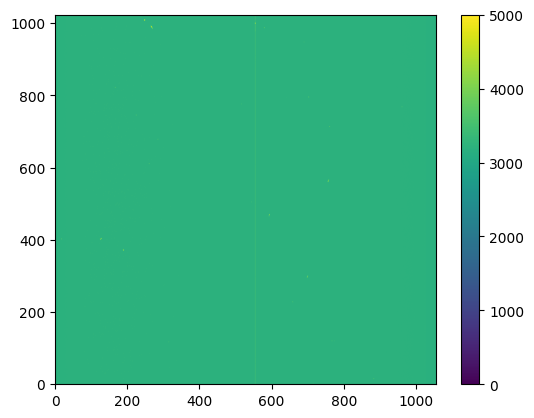

In [23]:
bias1 = fits.getdata(biases[0])
plt.imshow(bias1, origin='lower', vmin=0, vmax=5000)
plt.colorbar()

The image looks pretty uniform but the average value is definitely not zero. Let's take a look at the median and standard deviation to get a better idea of what is in the image. 

In [24]:
med_bias1 = np.median(bias1)
med_bias1

3212.0

In [25]:
std_bias1 = np.std(bias1)
std_bias1

22.05385730618298

Use the median and the standard deviation to set the minimum and maximum values for the color scaling. 

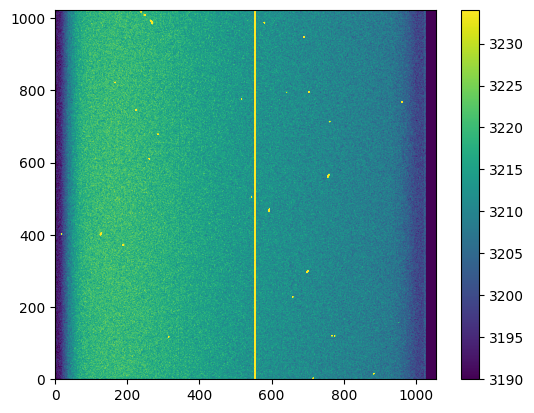

In [26]:
plt.imshow(bias1, origin='lower', vmin=(med_bias1-std_bias1), vmax=(med_bias1+std_bias1))
plt.colorbar()

With this tighter scaling, we can start to see some of the detector artifacts. If you look at a different bias image, does it look the same? What do you think the bright column in the middle of the image is? the dark column on the right of the image? 

We always take multiple bias frames (multiple frames of all types, bias, flat, science, ...) to manage the noise in the image. Let's see why. Read in all the bias frames and combine them into a master bias frame. 

In [27]:
bias_timestream = [fits.getdata(x) for x in biases]

Noise is random which means that it will be positive roughly as often as it will be negative. By combining multiple frames, we can reduce the noise to get a more accurate measure of the bias. 

In [28]:
# average of the bias frames 
mean_bias = np.mean(bias_timestream, axis=0)
# median 
median_bias = np.median(bias_timestream, axis=0)

Which should you use - the mean or the median? 

Display both the mean and the median bias frames. How do they compare?

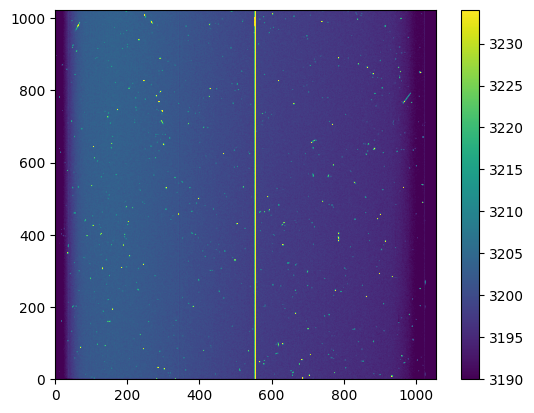

In [29]:
# mean-combined
plt.imshow(mean_bias, origin='lower', vmin=(med_bias1-std_bias1), vmax=(med_bias1+std_bias1))
plt.colorbar()

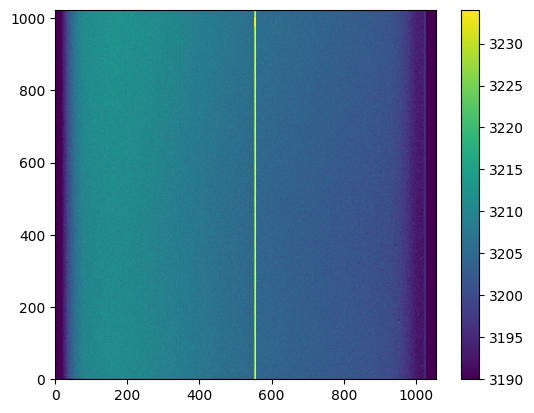

In [30]:
# median-combined 
plt.imshow(median_bias, origin='lower', vmin=(med_bias1-std_bias1), vmax=(med_bias1+std_bias1))
plt.colorbar()

The mean is affected by outliers whereas the median is not. Notice how many bright pixels you can see in the mean image (what are these?). So we'll use the median. 

### Does subtracting the bias strip do the same thing as subtracting a bias frame? 

Think about what both approaches are doing. Are you taking a median of several values in both cases? Does one provide a better measure of the bias as a function of time? Does one do a better job measuring variations in the bias as a function of position? 

Try both ways with your data and see which you like better. Does one do a better job? 

# Flat field correction

Pixels have an uneven response. Even for the same input signal, different pixels will record different counts. To quantify this, we take an image of a uniformly illuminated surface. This can be either a screen in the dome illuminated with a lamp or sometimes the twilight sky. If the detector response was perfect, every pixel would have the same number of counts. In reality, this will not be the case. A flatfield allows us to correct for these pixel-to-pixel variations. 

The flatfield filenames should be self-explanatory. For example, ‘V_0000.fits’ was the first flat image taken in the V filter, etc. Don't forget to trim the flatfield frames so they are the same size as your science image! 

In [31]:
Vflat = fits.open(path+'flats_feb2024/V_0000.fits')[0].data

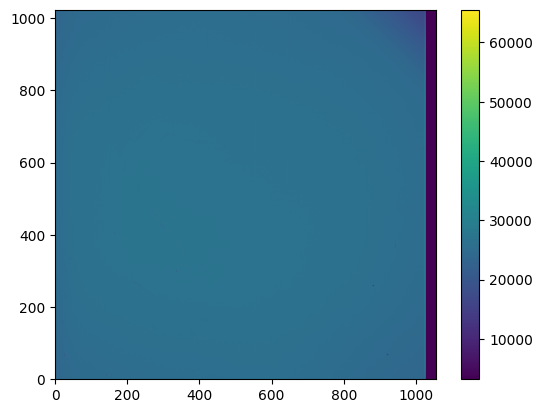

In [32]:
plt.imshow(Vflat, origin='lower')
plt.colorbar()

Like all other types of exposures, we never take just one flatfield. Read in all the flats and combine them to a master flat image for each band. 

In [33]:
Vflats = glob.glob(path+'flats_feb2024/V*.fits')
Vflats

['/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0001.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0000.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0007.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0006.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0010.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0005.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0009.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0008.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0004.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0003.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0002.fits']

In [34]:
Vflat_timestream = [fits.getdata(x)for x in Vflats]
mean_Vflat = np.mean(Vflat_timestream, axis=0)
median_Vflat = np.median(Vflat_timestream, axis=0)
del Vflat_timestream

This flatfield image still includes the bias signal so we subtract that from the flat field. 

In [35]:
bias_subtracted_Vflat = median_Vflat - median_bias

Next, we want to normalize the flat so its average value is ~1. You can think of this as a rating of the pixel response. If the pixel is working perfectly, we would get 100\% of the signal - no more, no less. Most pixels will be close to this but pixel response is not perfect so numbers will be a little below or above 1. What value would you expect for a dead pixel? 

Normalizing the flatfield image allows us to divide the science image by the flatfield image without reducing the number of counts in the science image. 

To normalize the flatfield inage, divide the flat by its mean so that the average value of the flat is ~1 everywhere. 

In [36]:
Vflat_mean = np.mean(bias_subtracted_Vflat)# wait - didn't we already take the mean? Why is this mean different? 
normalized_mean_Vflat = bias_subtracted_Vflat / Vflat_mean

In [37]:
np.mean(normalized_mean_Vflat)

1.0000000000000004

The image of the combined flatfield should look pretty smooth (i.e. flat). 

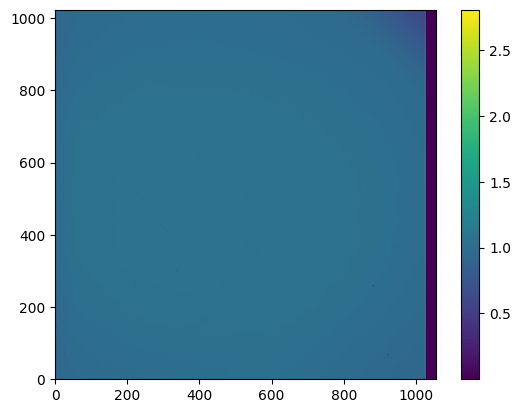

In [38]:
plt.imshow(normalized_mean_Vflat, origin='lower')
plt.colorbar()

However, if we change the colorscaling, we can start to see some of the artifacts that the flatfield corrects. 

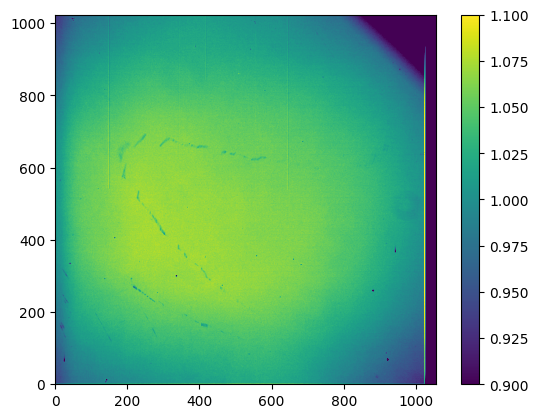

In [39]:
plt.imshow(normalized_mean_Vflat, origin='lower', vmin=0.9, vmax=1.1)
plt.colorbar()

In [40]:
trimmed_Vflat = normalized_mean_Vflat[y1:y2,x1:x2]

Now we can just divide the image by the flat field. 

In [41]:
ndata_ff = ndata_no_bias / trimmed_Vflat

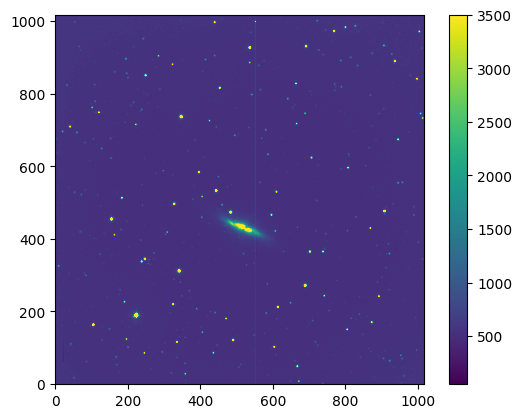

In [42]:
plt.imshow(ndata_ff, origin='lower', vmin=50, vmax=3500)
plt.colorbar()

# Dark Current

Dark current is an additional signal from the environment that builds up over time and varies with temperature. Dark frames are taken when the shutter is closed and no light is falling on the detector. The exposure time of the dark frames should be the same as the science images (why?). 

The procedure for processing darks is similar to making a master flat-field image. Read in the data and take the median. 

In [43]:
darks = glob.glob(path+'darks/*.fits')
darks

['/Users/mr82/teaching/data_for_ASTR230/darks/obj0063.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0059.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0055.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0054.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0058.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0062.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0061.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0057.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0056.fits',
 '/Users/mr82/teaching/data_for_ASTR230/darks/obj0060.fits']

In [44]:
darks_frms = [fits.getdata(x) for x in darks]
mean_dark = np.mean(darks_frms, axis=0)
median_dark = np.median(darks_frms, axis=0)
stddev_dark = np.std(darks_frms, axis=0)
del darks_frms

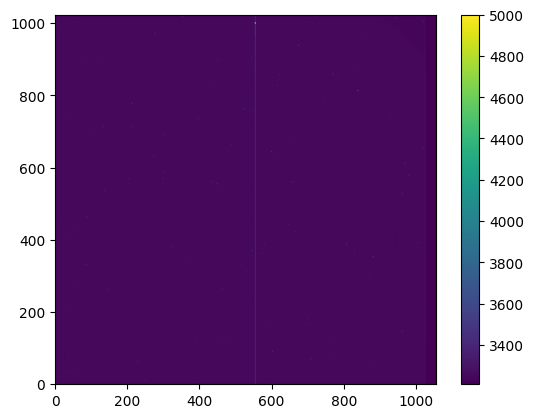

In [45]:
plt.imshow(mean_dark, origin='lower', vmax=5000)
plt.colorbar()

In [46]:
np.median(mean_dark)

3248.3

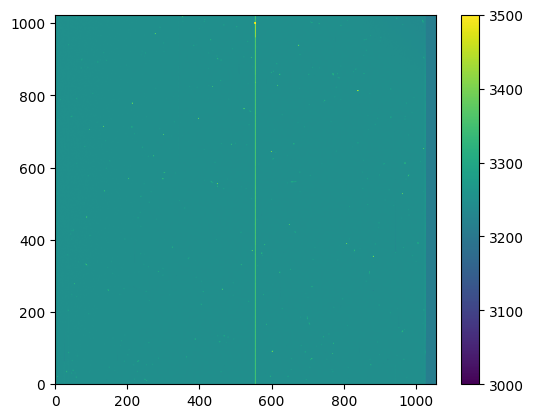

In [47]:
plt.imshow(mean_dark, origin='lower', vmin=3000, vmax=3500)
plt.colorbar()

Notice that the median of the dark frame is _very_ similar to the median of the bias image. 

In [48]:
np.median(mean_bias)

3198.409090909091

Even better, subtract the bias from the 

In [52]:
diff = median_dark - median_bias
np.nanmedian(diff)

45.0

The CCD on the McDonald 30" is cryocooled which significantly decreases the dark current. Because the dark current is so low for this cold detector, we usually skip this step for imaging at McDonald. 

When the dark current is signficant, this is subtracted from the science frame. **Be sure all your dark frames have the same exposure time as each other and your science data!** 

Question for you: if you subtract the dark current using a dark frame, do you also need to subtract the bias? 

# update the header and save the processed data

We should update the header to store the trim section and bias section we used, then write the data to a new file.

In [49]:
nheader = fheader # copy the original header
nheader['BIASSEC'] = "["+str(bx1)+":"+str(bx2)+","+str(y1)+":"+str(y2)+"]"
nheader['TRIMSEC'] = "["+str(x1)+":"+str(x2)+","+str(y1)+":"+str(y2)+"]"

Note the formatting. If were to just put quotes around the expression we used to extract the subarray, eg 
nheader['TRIMSEC'] = "[x1:x2,y1:y2]" 
we would end up with *exactly* that statement in the header. 

To get the numerical values we actually used, we have to change the data type from an integer to a string. We can check we did this correctly by printing the header. 

In [50]:
nheader

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1056 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
DATE    = '2024-02-15T05:49:33' / Date FITS file was generated                  
IRAF-TLM= '2024-02-15T05:48:40' / Time of last modification                     
OBJECT  = 'M82     '           / Name of the object observed                    
OBSERVAT= 'MCDONALD         

Finally, save the processed array to a new file. To make life easier in the future, pick a filename that tells you someting about the processing you've already done to the data. 

In [51]:
fits.writeto(path+"reduced/m82_V_ff.fits", ndata_ff, nheader, overwrite=True)